In [18]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import torch
import torchvision.models as models
import torch.nn as nn
import pandas as pd
from collections import OrderedDict
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader

from nachosv2.training.training_processing.custom_2D_dataset import Dataset2D
from nachosv2.setup.utils_training import get_files_labels_for_fold
from nachosv2.setup.utils_training import get_mean_stddev
from torchvision import transforms

In [19]:
df_metadata = pd.read_csv("/home/pcallec/analyze_images/results/pig_kidney_subset/pig_kidney_subset_metadata.csv")

In [20]:
df_metadata

,filename,absolute_filepath,fold_name,category,label
0,39_k4_medulla.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k4...,k4,medulla,1
1,15_k4_medulla.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k4...,k4,medulla,1
2,45_k4_medulla.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k4...,k4,medulla,1
3,64_k4_medulla.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k4...,k4,medulla,1
4,12_k4_medulla.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k4...,k4,medulla,1
...,...,...,...,...,...
1495,4_k3_cortex.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k3...,k3,cortex,0
1496,74_k3_cortex.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k3...,k3,cortex,0
1497,48_k3_cortex.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k3...,k3,cortex,0
1498,50_k3_cortex.jpg,/home/pcallec/NACHOS/data/pig_kidney_subset/k3...,k3,cortex,0


In [21]:
def get_model(model_name: str,
              number_classes: int,
              number_channels: int):
    # https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py
    # https://pytorch.org/vision/0.12/generated/torchvision.models.inception_v3.html
    if model_name == "InceptionV3":
        # For the parameter aux_logits, which uses and additional branch
        # to help with gradient flow, useful for vanishing gradient problem
        # If images are less than 299x299, then aux_logits=False
        # If images are at least 75x75, then aux_logits=True
        model = models.inception_v3(weights=None,
                                    init_weights=True,
                                    num_classes=number_classes,
                                    aux_logits=False)


        model.Conv2d_1a_3x3.conv = nn.Conv2d(
            in_channels=number_channels,  # Change to 1 channel for grayscale
            out_channels=model.Conv2d_1a_3x3.conv.out_channels,
            kernel_size=model.Conv2d_1a_3x3.conv.kernel_size,
            stride=model.Conv2d_1a_3x3.conv.stride,
            padding=model.Conv2d_1a_3x3.conv.padding,
            bias=model.Conv2d_1a_3x3.conv.bias  # is not None
        )
        
    elif model_name == "ResNet50":
        # ResNet50-specific logic
        model = models.resnet50(weights=None,
                                num_classes=number_classes)
        # Adjust the first convolutional layer to handle a different number of input channels
        model.conv1 = nn.Conv2d(
            in_channels=number_channels,
            out_channels=model.conv1.out_channels,
            kernel_size=model.conv1.kernel_size,
            stride=model.conv1.stride,
            padding=model.conv1.padding,
            bias=model.conv1.bias  # is not None
        )
    return model

In [22]:
model_inception = get_model("InceptionV3",
                  number_classes=3,
                  number_channels=1)  # Change to 1 channel for grayscale

In [23]:
model_inception.to("cuda")

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
checkpoint_path = '/home/pcallec/NACHOS/results/pig_kidney/CV/checkpoints/pig_kidney_test_k1_val_k2_epoch_11_best.pth'
checkpoint = torch.load(checkpoint_path,
                        weights_only=True)


In [25]:
model_inception.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [26]:
model_inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [27]:
partitions_info_dict = OrderedDict( # Dictionary of dictionaries
            [('training', {'files': [], 'labels': [], 'dataloader': None}),
             ('validation', {'files': [], 'labels': [], 'dataloader': None}),
             ('test', {'files': [], 'labels': [], 'dataloader': None}),
            ]
            )

In [28]:
partitions_info_dict = {'files': [], 'labels': [], 'dataloader': None}

In [29]:
type(df_metadata)

pandas.core.frame.DataFrame

In [30]:
partitions_info_dict['files'], partitions_info_dict['labels'] = get_files_labels_for_fold(
        df_metadata=df_metadata,
        fold_or_list_fold="k1")

In [33]:
dataset_before_normalization = Dataset2D(
    dictionary_partition = partitions_info_dict,
    number_channels = 1,
    image_size = (301, 235),
    do_cropping = False,
    crop_box = None,
    transform=None
)

dataloader = DataLoader(
    dataset = dataset_before_normalization,
    batch_size = 32,
    shuffle = False,
    drop_last = True,
    num_workers = 0 # Default
)

mean, stddev = get_mean_stddev(
    number_channels=1,
    dataloader=dataloader)

transform = transforms.Normalize(mean=mean, std=stddev)

dataset = Dataset2D(
    dictionary_partition = partitions_info_dict,
    number_channels = 1,
    image_size = (301, 235),
    do_cropping = False,
    crop_box = None,
    transform=transform
    )

dataloader = DataLoader(
    dataset = dataset,
    batch_size = 1,
    shuffle = False,
    drop_last = True,
    num_workers = 4
)

In [34]:
for i, (inputs, labels, filepath ) in enumerate(dataloader):
    inputs=inputs.to("cuda")
    
    outputs = model_inception(inputs)
    probabilities = torch.softmax(outputs, dim=1)
# Gets the predicted class indices
    _, class_predictions = torch.max(outputs, 1)
    print(i, filepath, class_predictions, labels)


0 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/48_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
1 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/26_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
2 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/53_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
3 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/41_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
4 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/72_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
5 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/3_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
6 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/99_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
7 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/19_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
8 ('/home

In [35]:
# 

data_iter = iter(dataloader)
first_value = next(data_iter)

In [36]:
inputs, labels, filepath = first_value

In [37]:
inputs

tensor([[[[-0.7004, -0.7004, -0.5649,  ..., -0.4971, -0.5140, -0.5479],
          [-0.6157, -0.6326, -0.5479,  ..., -0.5987, -0.5987, -0.6157],
          [-0.5479, -0.6496, -0.6157,  ..., -0.6157, -0.6326, -0.6326],
          ...,
          [-0.5649, -0.5649, -0.5818,  ..., -0.6665, -0.6496, -0.6157],
          [-0.5818, -0.5987, -0.6157,  ..., -0.6326, -0.5818, -0.4971],
          [-0.6665, -0.6665, -0.6665,  ..., -0.7004, -0.6157, -0.4971]]]])

In [38]:
# read unage using PIL
# Read image from '/home/pcallec/NACHOS/data/pig_kidney_subset/k2/k2_medulla/9_k2_medulla.jpg' Using Pillow

# Path to the image
image_path = '/home/pcallec/NACHOS/data/pig_kidney_subset/k2/k2_medulla/9_k2_medulla.jpg'

# Open the image using Pillow
image = Image.open(image_path)
# Convert the image to grayscale
# image_gray = image.convert('L')

# Normalize pixel values to the range [0, 1]
image_normalized = np.array(image)/255

In [39]:
def get_submodule_by_name(model, name: str):
    submodule = model
    for attr in name.split('.'):
        if attr.isdigit():
            submodule = submodule[int(attr)]
        else:
            submodule = getattr(submodule, attr)
    return submodule

In [41]:
layer = get_submodule_by_name(model_inception, "Mixed_7c.branch_pool")
print(layer)

BasicConv2d(
  (conv): Conv2d(2048, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)


In [44]:
txt = "m50800"
txt.isdigit()

False

In [47]:
for i, (inputs, labels, filepath ) in enumerate(dataloader):
    inputs = inputs.to("cuda")
    outputs = model_inception(inputs)
    probabilities = torch.softmax(outputs, dim=1)
    # Gets the predicted class indices
    _, class_predictions = torch.max(outputs, 1)
    print(i, filepath, class_predictions, labels)
    
    # target_layer = get_submodule_by_name(model,
    #                 config_dict["target_layer"])

0 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/48_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
1 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/26_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
2 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/53_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
3 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/41_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
4 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/72_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
5 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/3_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
6 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/99_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
7 ('/home/pcallec/NACHOS/data/pig_kidney_subset/k1/k1_medulla/19_k1_medulla.jpg',) tensor([1], device='cuda:0') tensor([1])
8 ('/home

In [50]:
class_predictions.item()

2

In [32]:
# TODO: see prediction, ground_truth and modify parameters for GRADCAM
 
# model = resnet50(pretrained=True)
target_layers = [model_inception.Mixed_7c.branch_pool]
input_tensor = inputs
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(2)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model_inception, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(image_normalized, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

# # Construct the CAM object once, and then re-use it on many images.
# with GradCAM(model=model_inception, target_layers=target_layers) as cam:
#   # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#   grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
#   # In this example grayscale_cam has only one image in the batch:
#   grayscale_cam = grayscale_cam[0, :]
#   # https://github.com/jacobgil/pytorch-grad-cam/blob/781dbc0d16ffa95b6d18b96b7b829840a82d93d1/pytorch_grad_cam/utils/image.py#L35
#   visualization = show_cam_on_image(
#     img = image_normalized,
#     mask= grayscale_cam,
#     use_rgb=True,
#     colormap = 2,  # cv2.COLORMAP_JET
#     image_weight=0.7,
#     )
#   # You can also get the model outputs without having to redo inference
#   model_outputs = cam.outputs

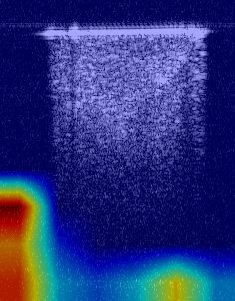

In [33]:
# plot using PIllow from numpy array

image = Image.fromarray(visualization)  # Scale to [0, 255] and convert to uint8

# Display the image
image

In [24]:
grayscale_cam

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.8356747, 0.8356747, 0.8356747, ..., 0.2813176, 0.2813176,
        0.2813176],
       [0.8356747, 0.8356747, 0.8356747, ..., 0.2813176, 0.2813176,
        0.2813176],
       [0.8356747, 0.8356747, 0.8356747, ..., 0.2813176, 0.2813176,
        0.2813176]], shape=(301, 235), dtype=float32)

In [28]:
# Read image from '/home/pcallec/NACHOS/data/pig_kidney_subset/k2/k2_medulla/9_k2_medulla.jpg' Using Pillow

# Path to the image
image_path = '/home/pcallec/NACHOS/data/pig_kidney_subset/k2/k2_medulla/9_k2_medulla.jpg'

# Open the image using Pillow
image = Image.open(image_path)
# Convert the image to grayscale
# image_gray = image.convert('L')

# Normalize pixel values to the range [0, 1]
image = np.array(image)


In [61]:
image_normalized.shape

(301, 235, 3)

In [63]:
inputs.shape

torch.Size([1, 1, 301, 235])

In [77]:
# model = resnet50(pretrained=True)
target_layers = [model_inception.Mixed_7c.branch_pool]
input_tensor =  inputs
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(2)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model_inception, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  # https://github.com/jacobgil/pytorch-grad-cam/blob/781dbc0d16ffa95b6d18b96b7b829840a82d93d1/pytorch_grad_cam/utils/image.py#L35
  visualization = show_cam_on_image(
    img = image_normalized,
    mask= grayscale_cam,
    use_rgb=True,
    colormap = 2,  # cv2.COLORMAP_JET
    image_weight=0.7,
    )
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

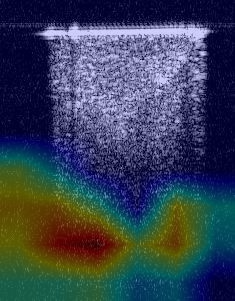

In [78]:
# plot using PIllow from numpy array

image = Image.fromarray(visualization)  # Scale to [0, 255] and convert to uint8

# Display the image
image

In [65]:
grayscale_cam.shape

(301, 235)

In [26]:
inputs[0,:,:,:].cpu().numpy().shape

(1, 351, 250)

In [16]:
outputs

tensor([[-35.3016,  83.4562, -49.1547],
        [  2.3063,  -0.7098,  -2.3243],
        [-50.0824,  80.9744, -46.7386],
        [  2.0924,   2.9318,  -5.8572],
        [-49.1158,  92.5245, -48.2926],
        [-32.5607,  79.4792, -44.9490],
        [-39.8628,  89.8465, -41.2032],
        [  2.5899,   2.4738,  -4.7078],
        [-43.1347,  72.6152, -43.6361],
        [-59.8104,  99.5866, -51.4169],
        [ -7.4460,  24.0594, -18.7511],
        [-32.4014,  82.6041, -53.4762],
        [-43.4701,  81.9092, -54.1080],
        [-10.8085,  22.7539, -14.5315],
        [-37.9611,  78.0022, -56.6332],
        [-69.5743, 119.0944, -43.9825],
        [-23.5947,  74.7318, -44.8391],
        [-56.6373, 114.3265, -41.2421],
        [-43.0399,  94.1595, -47.9027],
        [-54.2970,  97.6003, -48.9156],
        [-36.8421,  61.8491, -39.6203],
        [-45.7275,  80.7424, -48.9695],
        [-60.9013,  97.1384, -45.7684],
        [-45.0884,  97.6991, -44.2564],
        [-58.4995, 101.0082, -40.8232],


In [34]:
model_inception.Mixed_7c.branch_pool

BasicConv2d(
  (conv): Conv2d(2048, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

/home/pcallec/anaconda3/envs/grad-cam/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pcallec/anaconda3/envs/grad-cam/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/pcallec/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s] 


In [ ]:
for i, (inputs, labels, _ ) in enumerate(data_loader):

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
# model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(281)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

SyntaxError: invalid syntax (3408956556.py, line 3)

In [35]:
# model = resnet50(pretrained=True)
target_layers = [model_inception.Mixed_7c.branch_pool]

# input_tensor = # Create an input tensor image for your model..
# # Note: input_tensor can be a batch tensor with several images!

# # We have to specify the target we want to generate the CAM for.
# targets = [ClassifierOutputTarget(281)]

# # Construct the CAM object once, and then re-use it on many images.
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#   grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
#   # In this example grayscale_cam has only one image in the batch:
#   grayscale_cam = grayscale_cam[0, :]
#   visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
#   # You can also get the model outputs without having to redo inference
#   model_outputs = cam.outputs